# Task

The task is to predict salary based on the different features: 
* Text features:
    * Vacancy Title 
    * Vacancy Description
* Categorical features:
    * Category
    * Company
    * Location
    * Contract Type
    * Contract Time

We are going to be using Deep Learning approach to this problem.

# Imports

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.functional as F
import torch.nn as nn
from loguru import logger
from nltk.tokenize import TweetTokenizer
from scipy.stats import beta, shapiro
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

SEED = 42

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Metric

In this case, we will use MAE.

# Loading data

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.drop(["LocationRaw", "SalaryRaw", "SourceName", "Id"], axis=1, inplace=True)
data.shape

(244768, 8)

## Setting columns

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = [
    "Category",
    "Company",
    "LocationNormalized",
    "ContractType",
    "ContractTime",
]
target_column = "SalaryNormalized"

## Dataset overview

In [5]:
data.sample(10, random_state=SEED)

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
30390,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,23500
108709,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,23040
13924,Community Fundraising Manager,This dynamic international development charity...,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,34850
154606,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,22500
172891,Investment Compliance Analyst,This individual will work closely with the bus...,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,55000
164389,SAP Project Manager,SAP Project Manager My client is a management ...,London,NaN,permanent,NaN,IT Jobs,75000
109469,Sheet Metal Worker,SHEET METAL WORKER ABERDEEN Sheet Metal Worker...,Aberdeen,full_time,contract,NaN,Engineering Jobs,24960
214859,Domiciliary Care Trainer,A dedicated and experienced Domiciliary Care T...,Oxford,NaN,permanent,Vivico Recruitment,Healthcare & Nursing Jobs,22000
225029,Kitchen Manager Branded Restaurant,Kitchen Manager An exciting opportunity has ar...,Luton,NaN,NaN,Renard Resources,Hospitality & Catering Jobs,22500
149935,Computational Biologist,Computational Biologist ****K (depending on ex...,UK,NaN,permanent,Escape,Healthcare & Nursing Jobs,35000


## Missing values 

In [6]:
data.isna().sum()

Title                      1
FullDescription            0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryNormalized           0
dtype: int64

For now, let's just fill all the `NA` values with `NaN` 

In [7]:
data = data.fillna("NaN")

## Splitting data

In [8]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=SEED)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

data_train.shape, data_val.shape

((195814, 8), (48954, 8))

## Dataset Close Look

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195814 entries, 0 to 195813
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               195814 non-null  object
 1   FullDescription     195814 non-null  object
 2   LocationNormalized  195814 non-null  object
 3   ContractType        195814 non-null  object
 4   ContractTime        195814 non-null  object
 5   Company             195814 non-null  object
 6   Category            195814 non-null  object
 7   SalaryNormalized    195814 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 12.0+ MB


#### Target

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc.  
So, we will transform salary using `log1p` transformation.

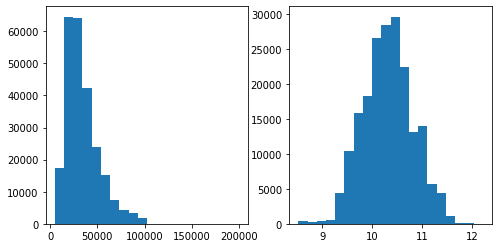

In [10]:
log1pSalary = np.log1p(data_train["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(log1pSalary, bins=20);

In [11]:
shapiro(log1pSalary)

C:\Users\ryblo\Documents\projects\yandex_nlp_course\venv\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9969059824943542, pvalue=2.802596928649634e-45)

We can see that the data is really lognormal

#### Categorical columns

In [12]:
for cat_column in categorical_columns:
    print(f"'{cat_column}' column contains {data_train[cat_column].nunique()} unique values")

'Category' column contains 29 unique values
'Company' column contains 18857 unique values
'LocationNormalized' column contains 2543 unique values
'ContractType' column contains 3 unique values
'ContractTime' column contains 3 unique values


##### Category column

In [13]:
data_train["Category"].value_counts()

IT Jobs                             30847
Engineering Jobs                    20159
Accounting & Finance Jobs           17434
Healthcare & Nursing Jobs           16916
Sales Jobs                          13849
Other/General Jobs                  13567
Teaching Jobs                       10137
Hospitality & Catering Jobs          9066
Trade & Construction Jobs            7088
PR, Advertising & Marketing Jobs     7070
HR & Recruitment Jobs                6190
Admin Jobs                           6112
Retail Jobs                          5201
Customer Services Jobs               4794
Legal Jobs                           3145
Manufacturing Jobs                   3027
Logistics & Warehouse Jobs           2912
Social work Jobs                     2743
Consultancy Jobs                     2591
Travel Jobs                          2508
Scientific & QA Jobs                 2010
Charity & Voluntary Jobs             1867
Energy, Oil & Gas Jobs               1821
Creative & Design Jobs            

##### Company column

In [14]:
data_train["Company"].value_counts()

NaN                                                      25884
UKStaffsearch                                             4015
CVbrowser                                                 2387
London4Jobs                                               1859
Hays                                                      1424
                                                         ...  
Oxford University Hospitals NHS Trust                        1
Aspirations Care                                             1
MANPOWER UK LTD                                              1
Zolv.com Ltd                                                 1
The Facial Surgery Research Foundation   Saving Faces        1
Name: Company, Length: 18857, dtype: int64

##### LocationNormalized column

In [15]:
data_train["LocationNormalized"].value_counts()

UK                   32767
London               24483
South East London     9411
The City              5337
Manchester            2859
                     ...  
Kilbarchan               1
Brompton                 1
Kennoway                 1
Kirkby Stephen           1
Grimethorpe              1
Name: LocationNormalized, Length: 2543, dtype: int64

##### ContractType column

In [16]:
data_train["ContractType"].value_counts()

NaN          143245
full_time     46208
part_time      6361
Name: ContractType, dtype: int64

##### ContractTime column

In [17]:
data_train["ContractTime"].value_counts()

permanent    121042
NaN           51332
contract      23440
Name: ContractTime, dtype: int64

## Preparing

### Tokenizer

I'll be using `TweetTokenizer`, because I like how it handles apostrophes (see below).

In [18]:
tokenizer = TweetTokenizer()
# tokenizer = nltk.tokenize.WordPunctTokenizer()

assert tokenizer.tokenize("I've been doing this for a few years!") == [
    "I've",
    "been",
    "doing",
    "this",
    "for",
    "a",
    "few",
    "years",
    "!",
]

## Preprocessor Class

Preprocessor class takes as input:
* `data` - dataframe with our dataset 
* `tokenizer` - to split sentences into tokens
* `min_count` - minimum count for building vocabulary  
* `max_len_title` - maximum number of words for the title
* `max_len_description` - maximum number of words for the description

In [19]:
class PreprocessDataset:
    TEXT_COLS = ["Title", "FullDescription"]
    CAT_COLS = [
        "Category",
        "Company",
        "LocationNormalized",
        "ContractType",
        "ContractTime",
    ]
    TARGET_COL = "SalaryNormalized"
    NEW_TARGET_COL = "Log1pSalary"
    UNK, PAD = "UNK", "PAD"
    SEED = 42

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer,
        min_count=10,
        max_len_title=None,
        max_len_description=None,
    ):
        self.tokenizer = tokenizer
        self.data = data

        self.data_train, self.data_val = self._split_data()

        self.data_train = self.preprocess_data(self.data_train, train=True)
        self.data_val = self.preprocess_data(self.data_val)

        self.categorical_vectorizer = self._preprocess_categorical()
        self.vocab = self._build_vocab(min_count)
        self.token_to_id = self._build_token_to_id_dict()
        self.UNK_IX, self.PAD_IX = map(self.token_to_id.get, [self.UNK, self.PAD])
        self.max_len_description = max_len_description
        self.max_len_title = max_len_title

    def preprocess_data(self, data, train=False):
        logger.info(f"Preprocessing {'Train' if train else 'Val'} data")
        data = self._preprocess_texts(data)
        data = self._preprocess_target(data)

        return data

    def _split_data(self, test_size=0.2):
        """Split dataset into train and validation sets with specified `test_size` and `random_state"""
        
        logger.info("Splitting data to train and val sets")

        data_train, data_val = train_test_split(self.data, test_size=test_size, random_state=self.SEED)
        data_train.reset_index(drop=True, inplace=True)
        data_val.reset_index(drop=True, inplace=True)

        return data_train, data_val

    def _preprocess_texts(self, data: pd.DataFrame) -> pd.DataFrame:
        """Tokenize text columns"""

        for text_col in self.TEXT_COLS:
            tqdm.pandas(desc=f"Tokenizing {text_col}")
            tokenized_texts = data[text_col].progress_apply(self._tokenize)
            data[text_col] = tokenized_texts.values

        return data

    def _preprocess_target(self, data: pd.DataFrame) -> pd.DataFrame:
        """Make `log1p` transformation for the target column"""

        logger.info("Preprocessing Target column")

        data[self.NEW_TARGET_COL] = np.log1p(data[self.TARGET_COL]).astype("float32")

        return data

    def _preprocess_categorical(self, most_common=1000):
        """Preprocess categorical columns (only use top 1000 companies)"""

        logger.info("Preprocessing Categorical columns")

        tqdm.pandas(desc=f"Preprocessing Company column")
        # we only consider top-1k most frequent companies to minimize memory usage
        top_companies, top_counts = zip(*Counter(self.data_train["Company"]).most_common(most_common))
        recognized_companies = set(top_companies)
        self.data_train["Company"] = self.data_train["Company"].progress_apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )

        tqdm.pandas(desc=f"Vectorizing categorical columns")
        categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
        categorical_vectorizer.fit(self.data_train[self.CAT_COLS].progress_apply(dict, axis=1))

        return categorical_vectorizer

    def _build_vocab(self, min_count):
        """Build vocabulary for the text columns considering `min_count`"""

        token_counts = Counter()

        # Count how many times does each token occur in both "Title" and "FullDescription" in total
        for str_ in tqdm(self.data_train[text_columns].values.flatten(), desc="Building vocab"):
            token_counts.update(str(str_).split())

        logger.debug(f"Total unique tokens: {len(token_counts)}")
        logger.debug("\n".join(map(str, token_counts.most_common(n=5))))
        logger.debug("\n".join(map(str, token_counts.most_common(n=5))))
        logger.debug("...")
        logger.debug("\n".join(map(str, token_counts.most_common()[-3:])))

        # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
        tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

        # Add a special tokens for unknown and empty words
        tokens = [self.UNK, self.PAD] + tokens

        logger.debug(f"Vocabulary size: {len(tokens)}")
        assert type(tokens) == list
        assert len(tokens) in range(30000, 35000)
        assert "me" in tokens
        assert self.UNK in tokens

        return tokens

    def _build_token_to_id_dict(self):
        """Build token-to-id dict"""

        token_to_id = {token: i for i, token in enumerate(self.vocab)}

        assert isinstance(token_to_id, dict)
        assert len(token_to_id) == len(self.vocab)
        for token in self.vocab:
            assert self.vocab[token_to_id[token]] == token

        return token_to_id

    def _tokenize(self, text):
        return " ".join(self.tokenizer.tokenize(str(text).lower()))

    def _as_matrix(self, sequences, max_len=None):
        """Convert a list of tokens into a matrix with padding"""

        if isinstance(sequences[0], str):
            sequences = list(map(str.split, sequences))

        max_len = min(max(map(len, sequences)), max_len or float("inf"))

        matrix = np.full((len(sequences), max_len), np.int32(self.PAD_IX))

        for i, seq in enumerate(sequences):
            row_ix = [self.token_to_id.get(word, self.UNK_IX) for word in seq[:max_len]]
            matrix[i, : len(row_ix)] = row_ix

        return matrix

In [20]:
preprocessor = PreprocessDataset(data, tokenizer, max_len_title=10, max_len_description=100)

2022-05-19 14:34:25.267 | INFO     | __main__:_split_data:47 - Splitting data to train and val sets
2022-05-19 14:34:25.310 | INFO     | __main__:preprocess_data:39 - Preprocessing Train data


Tokenizing Title:   0%|          | 0/195814 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/195814 [00:00<?, ?it/s]

2022-05-19 14:38:07.856 | INFO     | __main__:_preprocess_target:68 - Preprocessing Target column
2022-05-19 14:38:07.856 | INFO     | __main__:preprocess_data:39 - Preprocessing Val data


Tokenizing Title:   0%|          | 0/48954 [00:00<?, ?it/s]

Tokenizing FullDescription:   0%|          | 0/48954 [00:00<?, ?it/s]

2022-05-19 14:39:04.257 | INFO     | __main__:_preprocess_target:68 - Preprocessing Target column
2022-05-19 14:39:04.265 | INFO     | __main__:_preprocess_categorical:77 - Preprocessing Categorical columns


Preprocessing Company column:   0%|          | 0/195814 [00:00<?, ?it/s]

Vectorizing categorical columns:   0%|          | 0/195814 [00:00<?, ?it/s]

Building vocab:   0%|          | 0/391628 [00:00<?, ?it/s]

2022-05-19 14:39:15.765 | DEBUG    | __main__:_build_vocab:102 - Total unique tokens: 201108
2022-05-19 14:39:15.781 | DEBUG    | __main__:_build_vocab:103 - ('and', 2123081)
(',', 1871868)
('.', 1758719)
('*', 1674219)
('the', 1659371)
2022-05-19 14:39:15.797 | DEBUG    | __main__:_build_vocab:104 - ('and', 2123081)
(',', 1871868)
('.', 1758719)
('*', 1674219)
('the', 1659371)
2022-05-19 14:39:15.797 | DEBUG    | __main__:_build_vocab:105 - ...
2022-05-19 14:39:15.837 | DEBUG    | __main__:_build_vocab:106 - ('pate', 1)
('nurseportadown', 1)
('www.salestarget.co.uk/jobseeking/salesexecutivesx2northwestlondonesp***_job***', 1)
2022-05-19 14:39:15.853 | DEBUG    | __main__:_build_vocab:114 - Vocabulary size: 31171


## Dataset & Dataloaders & Transforms

### Transforms

We have two Transforms classes: 
* `ApplyWordDropout` for applaying word dropout
* `ToTensor` for converting our data to tensor

In [21]:
class ApplyWordDropout:
    def __init__(self, replace_with, pad_ix, word_dropout=0.0):
        self.keep_prop = 1.0 - word_dropout
        self.replace_with = replace_with
        self.pad_ix = pad_ix

    def apply_word_dropout(self, matrix):
        dropout_mask = np.random.choice(2, np.shape(matrix), p=[self.keep_prop, 1 - self.keep_prop])
        dropout_mask &= matrix != self.pad_ix

        return np.choose(dropout_mask, [matrix, np.full_like(matrix, self.replace_with)])

    def __call__(self, sample):
        return self.apply_word_dropout(sample)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, device=DEVICE):
        sample_tensors = dict()
        for key, arr in sample.items():
            if key in ["FullDescription", "Title"]:
                sample_tensors[key] = torch.tensor(arr, dtype=torch.long, device=device)
            else:
                sample_tensors[key] = torch.tensor(arr, device=device)
        return sample_tensors

### Dataset

Standard dataset class for PyTorch, which have methods to get the length of the dataset and to get the item for given id.

In [22]:
class VacancyDataset:
    def __init__(self, preprocessor, train=True, transform=None, word_dropout=0):
        self.preprocessor = preprocessor

        self.data = self.preprocessor.data_train if train else preprocessor.data_val

        self.transform = transform
        self.word_dropout = ApplyWordDropout(
            replace_with=self.preprocessor.UNK_IX,
            pad_ix=self.preprocessor.PAD_IX,
            word_dropout=word_dropout,
        )

        self.title = self.preprocessor._as_matrix(self.data["Title"].values, self.preprocessor.max_len_title)
        self.description = self.preprocessor._as_matrix(
            self.data["FullDescription"].values,
            self.preprocessor.max_len_description,
        )

        if word_dropout != 0:
            self.description = self.word_dropout(self.description)

        self.categorical = self.preprocessor.categorical_vectorizer.transform(
            self.data[self.preprocessor.CAT_COLS].apply(dict, axis=1)
        )

        self.target = self.data[self.preprocessor.NEW_TARGET_COL]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {}
        sample["title_text"] = self.title[idx]
        sample["description_text"] = self.description[idx]
        sample["categorical"] = self.categorical[idx]
        sample["target"] = self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
training_data = VacancyDataset(preprocessor, train=True, transform=ToTensor())
test_data = VacancyDataset(preprocessor, train=False, transform=ToTensor())

We can look at our data we've prepared for training

In [24]:
training_data[0]

{'title_text': tensor([24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
        device='cuda:0', dtype=torch.int32),
 'description_text': tensor([24816, 26825, 30259, 29588,   819, 24816, 26825, 30259, 14759, 29588,
         11235,   819, 23396, 24881, 13932,     0,    14, 25722,    14, 11235,
         23397, 30147, 15941,  8200,    14, 20844,  8286,    14,  1106,  3973,
         14235,  1927,     0, 21736,    15, 27600, 13699,  4640, 30041, 12710,
          9263,  1883, 19240,    12,    12,    12,    16,    12,    12,    12,
         30147,  2591, 15954,   819, 31005, 10309, 30158, 27696, 10848,    14,
         21486,  2591,   819, 24816, 16073,    15, 27600, 24816, 26825, 30259,
         30041, 12710, 27916,  3220,   898, 27916,  6152,  1927, 13886,  4739,
         20988,    14,  2389, 29809,  2389,  2328, 14063,  7402, 19941,  1927,
          9527, 23397, 27916, 27125,  1883,  1140, 23897, 13932,  1669,  2467],
        device='cuda:0', dtype=torch.int32),
 'cat

### Dataloaders

Just to check that everything is working fine!

In [25]:
dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
batch = next(iter(dataloader))
batch

{'title_text': tensor([[ 9176, 22774,  6487, 31140, 16942,     1,     1,     1,     1,     1],
         [17396, 11009,    16, 17394,  1557, 26825,  9831,  1927, 29176,     1],
         [13223, 16910, 15888,    16, 17642, 29630,     1,     1,     1,     1],
         [16843,  9601,     1,     1,     1,     1,     1,     1,     1,     1],
         [ 9311, 10956,  1927, 24671, 10848, 24233, 16910,     1,     1,     1],
         [12903,  7981,  1927, 15268,  1905,     1,     1,     1,     1,     1],
         [ 2126, 26825,  9601, 22550,    14, 26041,    14, 28795,  7465, 29604],
         [22774,  6487,     1,     1,     1,     1,     1,     1,     1,     1],
         [21750,  9601,     1,     1,     1,     1,     1,     1,     1,     1],
         [20984,  9601,    14,  6474, 11451,     1,     1,     1,     1,     1],
         [17396,  7961,     0, 19703,  6384,    16,  4488,     1,     1,     1],
         [24816,  1016, 16910,     1,     1,     1,     1,     1,     1,     1],
         [2423

# Model

## Base Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

PyTorch doesn't have implementation for the Global Max Pooling, so we'll implement it ourselves.

In [26]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

### Title Encoder

Implementation of Title Encoder as shown on the picture above

In [27]:
class BaseTitleEncoder(nn.Module):
    def __init__(self, n_tokens, pad_ix, hid_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> relu -> global_max
        """
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding(n_tokens, 32, padding_idx=pad_ix)
        self.conv1 = nn.Conv1d(32, hid_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()

    def forward(self, batch):
        # YOUR CODE HERE

        x = self.emb(batch)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        x = torch.transpose(x, 1, 2)

        c = self.conv1(x)
        p = self.pool1(self.relu(c))

        return p

In [28]:
title_encoder = BaseTitleEncoder(n_tokens=len(preprocessor.vocab), pad_ix=preprocessor.PAD_IX, hid_size=64)
title_encoder.to(DEVICE)

dummy_x = Variable(batch["title_text"])
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


In [29]:
batch = training_data[:2]
batch

{'title_text': tensor([[24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
         [26233,    16, 17204, 17979, 13932, 20771,  3591,     1,     1,     1]],
        device='cuda:0', dtype=torch.int32),
 'description_text': tensor([[24816, 26825, 30259, 29588,   819, 24816, 26825, 30259, 14759, 29588,
          11235,   819, 23396, 24881, 13932,     0,    14, 25722,    14, 11235,
          23397, 30147, 15941,  8200,    14, 20844,  8286,    14,  1106,  3973,
          14235,  1927,     0, 21736,    15, 27600, 13699,  4640, 30041, 12710,
           9263,  1883, 19240,    12,    12,    12,    16,    12,    12,    12,
          30147,  2591, 15954,   819, 31005, 10309, 30158, 27696, 10848,    14,
          21486,  2591,   819, 24816, 16073,    15, 27600, 24816, 26825, 30259,
          30041, 12710, 27916,  3220,   898, 27916,  6152,  1927, 13886,  4739,
          20988,    14,  2389, 29809,  2389,  2328, 14063,  7402, 19941,  1927,
           9527, 23397, 27916, 27125, 

In [30]:
emb = nn.Embedding(
    num_embeddings=len(preprocessor.vocab), embedding_dim=10, padding_idx=preprocessor.PAD_IX, device=DEVICE
)
title, embedded_title = batch["title_text"], emb(batch["title_text"])
title, embedded_title

(tensor([[24816, 26825, 30259,     1,     1,     1,     1,     1,     1,     1],
         [26233,    16, 17204, 17979, 13932, 20771,  3591,     1,     1,     1]],
        device='cuda:0', dtype=torch.int32),
 tensor([[[-0.7320,  0.9132, -0.4246,  0.8031,  1.0000,  1.8740, -0.8099,
           -0.2754, -0.6593,  0.3797],
          [-0.5913,  1.2903, -0.0850, -0.0205, -0.0640, -0.8971,  2.0486,
           -1.2139,  1.2958, -0.7082],
          [-0.0417, -1.2509, -0.2800,  0.0814,  0.4712,  0.0078,  0.3499,
           -0.0745, -0.5263, -0.9447],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000],
 

In [31]:
embedded_title.shape

torch.Size([2, 10, 10])

In [32]:
torch.transpose(embedded_title, 1, 2).shape

torch.Size([2, 10, 10])

### Description Encoder

Implementation of Description Encoder as shown on the picture above

In [33]:
class BaseDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens, pad_ix, hid_size=64):
        """
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> relu -> global_max
        """
        super().__init__()
        self.relu = nn.ReLU()
        self.emb = nn.Embedding(n_tokens, 32, padding_idx=pad_ix)
        self.conv1 = nn.Conv1d(32, hid_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()

    def forward(self, batch):
        # YOUR CODE HERE

        x = self.emb(batch)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        x = torch.transpose(x, 1, 2)

        c = self.conv1(x)
        p = self.pool1(self.relu(c))

        return p

In [34]:
description_encoder = BaseDescriptionEncoder(n_tokens=len(preprocessor.vocab), pad_ix=preprocessor.PAD_IX, hid_size=64)
description_encoder.to(DEVICE)

dummy_x = Variable(batch["description_text"])
dummy_v = description_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del description_encoder
print("Seems fine")

Seems fine


### Salary Predictor

Fusion: Title Encoder + Description Encoder + Categorical Encoder + FC Layers

In [35]:
class BaseSalaryPredictor(nn.Module):
    def __init__(self, n_cat_features, n_tokens, pad_ix, hid_size=64):
        super().__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.title_encoder = BaseTitleEncoder(n_tokens=n_tokens, pad_ix=pad_ix, hid_size=64)
        self.desc_encoder = BaseDescriptionEncoder(n_tokens=n_tokens, pad_ix=pad_ix, hid_size=64)

        self.cat_dense1 = nn.Linear(n_cat_features, hid_size)
        self.cat_dense2 = nn.Linear(hid_size, hid_size)

        self.out_dense1 = nn.Linear(192, 100)
        self.out_dense2 = nn.Linear(100, 1)

    def forward(self, batch):
        # process each data source with it's respective encoder
        title_h = self.title_encoder(batch["title_text"])
        desc_h = self.desc_encoder(batch["description_text"])

        # apply categorical encoder
        cat_h = self.relu(self.cat_dense1(batch["categorical"]))
        cat_h = self.cat_dense2(cat_h)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        joint_h = self.out_dense1(joint_h)
        joint_h = self.relu(joint_h)
        joint_h = self.out_dense2(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return joint_h[:, 0]

In [36]:
model = BaseSalaryPredictor(
    n_cat_features=len(preprocessor.categorical_vectorizer.vocabulary_),
    n_tokens=len(preprocessor.vocab),
    pad_ix=preprocessor.PAD_IX,
)
model.to(DEVICE)

criterion = nn.L1Loss()

batch = next(iter(dataloader))

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch["target"])
assert dummy_pred.shape == torch.Size([64])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0.0 <= dummy_loss <= 250.0, "make sure you minimize MAE"

## Training and evaluation

### Hyperparameters

In [37]:
learning_rate = 1e-4
batch_size = 32
epochs = 5

### Optimization loop

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    iter_size = 1000
    for batch_num, batch in enumerate(dataloader):
        # Compute prediction and loss
        y = batch["target"]
        pred = model(batch)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % iter_size == 0:
            loss, current = loss.item(), batch_num * len(y)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    squared_error = abs_error = num_samples = 0.0
    test_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            y = batch["target"]
            pred = model(batch)

            test_loss += loss_fn(pred, y).item()

            squared_error += torch.sum(torch.square(pred - y))
            abs_error += torch.sum(torch.abs(pred - y))
            num_samples += len(pred)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    test_loss /= num_batches

    print(f"Test Error: \n MSE: {mse:>0.2f}, MAE: {mae:>0.2f}, Avg loss: {test_loss:>8f} \n")

### Dataloaders

In [39]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Training

In [40]:
model = BaseSalaryPredictor(
    n_cat_features=len(preprocessor.categorical_vectorizer.vocabulary_),
    n_tokens=len(preprocessor.vocab),
    pad_ix=preprocessor.PAD_IX,
)
model.to(DEVICE)

loss_fn = nn.L1Loss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 334.780151  [    0/195814]
loss: 9.446263  [32000/195814]
loss: 11.764561  [64000/195814]
loss: 11.522502  [96000/195814]
loss: 8.767136  [128000/195814]
loss: 9.265714  [160000/195814]
loss: 9.236448  [192000/195814]
Test Error: 
 MSE: 0.12, MAE: 0.26, Avg loss: 8.445479 

Epoch 2
-------------------------------
loss: 8.999011  [    0/195814]
loss: 11.923000  [32000/195814]
loss: 9.187837  [64000/195814]
loss: 8.116298  [96000/195814]
loss: 7.326610  [128000/195814]
loss: 7.400521  [160000/195814]
loss: 6.846798  [192000/195814]
Test Error: 
 MSE: 0.10, MAE: 0.24, Avg loss: 7.628371 

Epoch 3
-------------------------------
loss: 7.218437  [    0/195814]
loss: 9.125703  [32000/195814]
loss: 6.340958  [64000/195814]
loss: 9.970930  [96000/195814]
loss: 6.718946  [128000/195814]
loss: 7.820122  [160000/195814]
loss: 4.916142  [192000/195814]
Test Error: 
 MSE: 0.10, MAE: 0.23, Avg loss: 7.342856 

Epoch 4
-------------------------------
loss

In [41]:
torch.save(model, "model.pth")